## This notebook demonstrates the Second step to automatic counting of Bollworms using images.

* Regression: We will be using Tensorflow library+some heavy data augmentation using TF Vision augmentation + inception_resnet_v2 as a regression model.
* Inference


In [ ]:
pip install timm

## Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import os
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Fix Hyperparameters and fix seed

In [3]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 500
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 1e-2
IMAGE_SIZE = 500


def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [4]:
def load_image(is_labelled: bool, is_training=True):
    """Wrapper function that returns a function
    for loading a single image if is_labelled=False
    or a function for loading image in an image-label pair
    if is_labelled=True.
    :param is_labelled: Boolean argument defining the return
    :param is_training: Boolean argument for image augmentation
    :return: Function
    """
    def _get_image(path: str) -> tf.Tensor:
        """Function loads image from a file.
        :param path: Path to image file
        :return: Tensor with preprocessed image
        """
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.cast(image, dtype=tf.int32)
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
        if is_training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.1, 0.2)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_hue(image, 0.1)
        return tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    def _get_image_label(img: tf.Tensor, label: int) -> tuple:
        """Function loads the image in an image-label pair.
        :param img: Tensor with original image
        :param label: Target value
        :return: Tuple with TF tensor and label
        """
        return _get_image(img), label

    return _get_image_label if is_labelled else _get_image


def prepare_dataset(dataset, is_training=True, is_labeled=True):
    """Function transforms a TF dataset containing file paths
    or file paths and labels to a dataset with image tensors and labels.
    :param dataset: Original dataset
    :param is_training: Argument defines if shuffling and image augmentation should be applied
    :param is_labeled: Argument defines if the dataset contains labels
    :return: Updated dataset
    """
    image_read_fn = load_image(is_labeled, is_training)
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.EfficientNetB6(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model


def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()


In [6]:
train = pd.read_csv('/kaggle/input/train-data/Train.csv')
files_dir = '/kaggle/input/images-resized-500/images_resized'

def add_path(x):
    return files_dir+'/'+x
train['image_id_worm']=train['image_id_worm'].apply(add_path)


In [8]:
# Create train and validation data sets.
data_train = train.head(7754)
data_valid = train.tail(2000)

ds_train = tf.data.Dataset.from_tensor_slices((data_train['image_id_worm'], data_train['number_of_worms']))
ds_valid = tf.data.Dataset.from_tensor_slices((data_valid['image_id_worm'], data_valid['number_of_worms']))

ds_train = prepare_dataset(ds_train)
ds_valid = prepare_dataset(ds_valid, is_training=False)

In [ ]:
# Load the model.
model = create_model()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE,
    restore_best_weights=True)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=1, cooldown=1, verbose=1,
    factor=0.75, min_lr=1e-8)

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=EPOCHS, callbacks=[early_stop, lr_reduction],
                    use_multiprocessing=True, workers=os.cpu_count())
model.save('EfficientNetB6_model.h5')

In [6]:
model = tf.keras.models.load_model('/kaggle/working/my_model')

In [ ]:
# Check its architecture
model.summary()

## Train Inception models weights for 10 epochs

In [9]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_valid, verbose=2)

2022-11-21 16:47:23.227447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-21 16:47:53.523238: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
Cleanup called...


485/485 - 969s - loss: 213.7040 - mean_absolute_error: 8.4248 - val_loss: 507.6178 - val_mean_absolute_error: 12.8694
Epoch 2/20


Cleanup called...


485/485 - 914s - loss: 81.9560 - mean_absolute_error: 5.2004 - val_loss: 676.8386 - val_mean_absolute_error: 12.5287
Epoch 3/20


Cleanup called...


485/485 - 916s - loss: 42.8130 - mean_absolute_error: 3.9741 - val_loss: 1244.4697 - val_mean_absolute_error: 14.8904
Epoch 4/20


Cleanup called...


485/485 - 917s - loss: 34.3710 - mean_absolute_error: 3.4663 - val_loss: 465.7761 - val_mean_absolute_error: 12.5856
Epoch 5/20


Cleanup called...


485/485 - 917s - loss: 52.0646 - mean_absolute_error: 3.9352 - val_loss: 493.7342 - val_mean_absolute_error: 13.6580
Epoch 6/20


Cleanup called...


485/485 - 916s - loss: 36.5842 - mean_absolute_error: 3.3929 - val_loss: 423.0193 - val_mean_absolute_error: 10.3244
Epoch 7/20


Cleanup called...


485/485 - 915s - loss: 29.9561 - mean_absolute_error: 3.2626 - val_loss: 396.0219 - val_mean_absolute_error: 9.7598
Epoch 8/20


Cleanup called...


485/485 - 916s - loss: 26.5412 - mean_absolute_error: 2.9725 - val_loss: 408.3512 - val_mean_absolute_error: 10.4804
Epoch 9/20


Cleanup called...


485/485 - 916s - loss: 30.0334 - mean_absolute_error: 3.0092 - val_loss: 889.7821 - val_mean_absolute_error: 14.9109
Epoch 10/20


Cleanup called...


485/485 - 915s - loss: 25.6883 - mean_absolute_error: 2.9301 - val_loss: 427.8455 - val_mean_absolute_error: 12.0084
Epoch 11/20


Cleanup called...


485/485 - 915s - loss: 27.9817 - mean_absolute_error: 2.8938 - val_loss: 439.5059 - val_mean_absolute_error: 13.0326
Epoch 12/20


Cleanup called...


485/485 - 913s - loss: 26.3216 - mean_absolute_error: 2.9399 - val_loss: 422.2366 - val_mean_absolute_error: 9.5655
Epoch 13/20


Cleanup called...


485/485 - 914s - loss: 22.8662 - mean_absolute_error: 2.6277 - val_loss: 422.0110 - val_mean_absolute_error: 10.4213
Epoch 14/20


Cleanup called...


485/485 - 914s - loss: 17.3089 - mean_absolute_error: 2.3636 - val_loss: 332.3825 - val_mean_absolute_error: 9.5541
Epoch 15/20


Cleanup called...


485/485 - 914s - loss: 18.0932 - mean_absolute_error: 2.4660 - val_loss: 289.9816 - val_mean_absolute_error: 8.9835
Epoch 16/20


Cleanup called...


485/485 - 914s - loss: 18.3395 - mean_absolute_error: 2.4590 - val_loss: 334.5366 - val_mean_absolute_error: 10.1603
Epoch 17/20


Cleanup called...


485/485 - 914s - loss: 19.5401 - mean_absolute_error: 2.5034 - val_loss: 3109.7913 - val_mean_absolute_error: 13.6827
Epoch 18/20


Cleanup called...


485/485 - 914s - loss: 21.6801 - mean_absolute_error: 2.5060 - val_loss: 398.8112 - val_mean_absolute_error: 9.2514
Epoch 19/20


Cleanup called...


485/485 - 915s - loss: 14.6849 - mean_absolute_error: 2.1296 - val_loss: 316.9855 - val_mean_absolute_error: 8.6946
Epoch 20/20


Cleanup called...


485/485 - 915s - loss: 12.9507 - mean_absolute_error: 2.0120 - val_loss: 420.5216 - val_mean_absolute_error: 10.8474


NameError: name 'plot_hist' is not defined

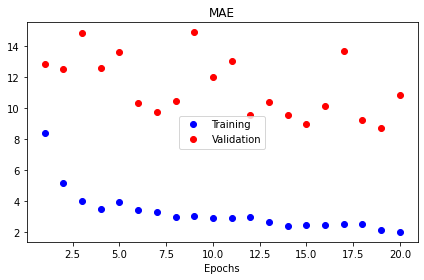

In [10]:
plot_history(hist)

In [11]:
model.save('InceptionV2_trained_layers.h5')

In [7]:
model = tf.keras.models.load_model('/kaggle/working/InceptionV2_trained_layers.h5')

In [8]:
test = pd.read_csv('/kaggle/input/train-data/Test.csv')
files_dir = '/kaggle/input/images-resized-500/images_resized'

def add_path(x):
    return files_dir+'/'+x
test['image_id_worm']=test['image_id_worm'].apply(add_path)
test

,image_id_worm
0,/kaggle/input/images-resized-500/images_resize...
1,/kaggle/input/images-resized-500/images_resize...
2,/kaggle/input/images-resized-500/images_resize...
3,/kaggle/input/images-resized-500/images_resize...
4,/kaggle/input/images-resized-500/images_resize...
...,...
2798,/kaggle/input/images-resized-500/images_resize...
2799,/kaggle/input/images-resized-500/images_resize...
2800,/kaggle/input/images-resized-500/images_resize...
2801,/kaggle/input/images-resized-500/images_resize...


In [ ]:
mse, mae = new_model.evaluate(ds_valid)
print(f'Validation MSE = {mse}\n'
      f'Validation MAE = {mae}')

In [9]:
data_test = test

ds_test = tf.data.Dataset.from_tensor_slices(data_test['image_id_worm'])
ds_test = prepare_dataset(ds_test, is_training=False,is_labeled=False)

In [10]:
preds = model.predict(ds_test)

2022-11-21 23:31:51.716582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-21 23:31:59.607895: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [21]:
sub = pd.read_csv('/kaggle/input/test-file-with-classification/Submission (1).csv')
sub

,image_id_worm,label
0,id_00332970f80fa9a47a39516d.jpg,abw
1,id_0035981bc3ae42eb5b57a317.jpg,pbw
2,id_005102f664b820f778291dee.jpg,abw
3,id_0066456f5fb2cd858c69ab39.jpg,abw
4,id_007159c1fa015ba6f394deeb.jpg,NaN
...,...,...
2798,id_ffad8f3773a4222f8fe5ba1a.jpg,pbw
2799,id_ffb65e6de900c49d8f2ef95a.jpg,pbw
2800,id_ffbcb27fa549278f47505515.jpg,NaN
2801,id_ffc0e41e10b0c964d4a02811.jpg,NaN


In [22]:
sub['label']=sub['label'].fillna(0)
sub['number_of_worms']=(np.round(preds))
sub.loc[sub.label == 0, 'number_of_worms'] = 0
sub

,image_id_worm,label,number_of_worms
0,id_00332970f80fa9a47a39516d.jpg,abw,0.0
1,id_0035981bc3ae42eb5b57a317.jpg,pbw,20.0
2,id_005102f664b820f778291dee.jpg,abw,6.0
3,id_0066456f5fb2cd858c69ab39.jpg,abw,-0.0
4,id_007159c1fa015ba6f394deeb.jpg,0,0.0
...,...,...,...
2798,id_ffad8f3773a4222f8fe5ba1a.jpg,pbw,6.0
2799,id_ffb65e6de900c49d8f2ef95a.jpg,pbw,59.0
2800,id_ffbcb27fa549278f47505515.jpg,0,0.0
2801,id_ffc0e41e10b0c964d4a02811.jpg,0,0.0


In [26]:
sub['label'].value_counts()

pbw    1531
0       826
abw     446
Name: label, dtype: int64

In [14]:
newdf = pd.DataFrame(np.repeat(sub.values,2, axis=0), columns=sub.columns)
newdf

,image_id_worm,label,number_of_worms
0,id_00332970f80fa9a47a39516d.jpg,abw,0.0
1,id_00332970f80fa9a47a39516d.jpg,abw,0.0
2,id_0035981bc3ae42eb5b57a317.jpg,pbw,20.0
3,id_0035981bc3ae42eb5b57a317.jpg,pbw,20.0
4,id_005102f664b820f778291dee.jpg,abw,6.0
...,...,...,...
5601,id_ffbcb27fa549278f47505515.jpg,0,0.0
5602,id_ffc0e41e10b0c964d4a02811.jpg,0,0.0
5603,id_ffc0e41e10b0c964d4a02811.jpg,0,0.0
5604,id_fff8c253115aacded09ad7ed.jpg,pbw,1.0


In [15]:
for i in range(0,len(newdf),2):
    if 'jpg' in newdf['image_id_worm'].iloc[i] :
        newdf['image_id_worm'].iloc[i]=newdf['image_id_worm'].iloc[i][:-4]+'_abw'
    else :
        newdf['image_id_worm'].iloc[i]=newdf['image_id_worm'].iloc[i][:-5]+'_abw'
    if 'jpg' in newdf['image_id_worm'].iloc[i+1]:
        newdf['image_id_worm'].iloc[i+1]=newdf['image_id_worm'].iloc[i+1][:-4]+'_pbw'
    else :
        newdf['image_id_worm'].iloc[i+1]=newdf['image_id_worm'].iloc[i+1][:-5]+'_pbw'


In [16]:
for i in range(0,len(newdf)):
    if  str(newdf['label'].iloc[i]) not in newdf['image_id_worm'].iloc[i]:
        newdf['number_of_worms'].iloc[i]=0
newdf    

,image_id_worm,label,number_of_worms
0,id_00332970f80fa9a47a39516d_abw,abw,0.0
1,id_00332970f80fa9a47a39516d_pbw,abw,0
2,id_0035981bc3ae42eb5b57a317_abw,pbw,0
3,id_0035981bc3ae42eb5b57a317_pbw,pbw,20.0
4,id_005102f664b820f778291dee_abw,abw,6.0
...,...,...,...
5601,id_ffbcb27fa549278f47505515_pbw,0,0.0
5602,id_ffc0e41e10b0c964d4a02811_abw,0,0.0
5603,id_ffc0e41e10b0c964d4a02811_pbw,0,0.0
5604,id_fff8c253115aacded09ad7ed_abw,pbw,0


In [17]:
newdf.drop(['label'], axis=1,inplace=True)
#newdf.rename(columns = {'image_id_worm':'Image_id'}, inplace = True)

In [18]:
newdf.to_csv('sub9.csv',index=False)